<a href="https://colab.research.google.com/github/gclausen0272/DataCamp-/blob/main/hackathon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon #2

Written by Eleanor Quint

Topics: 
- Dense layers
- Training by minibatch/gradient step and epoch
- Splitting the dataset into train/validation

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [ ]:
# %matplotlib inline
# We'll start with our library imports...
from __future__ import print_function
from google.colab.patches import cv2_imshow 
import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

### A First Attempt at Classifying MNIST

MNIST is a dataset of greyscale 28x28 handwritten digits labelled 0 through 9. We'll use it for a 10-class problem to learn the basics of classification.

Let's have a look at the data first. We'll load the data from [Tensorflow Datasets](https://www.tensorflow.org/datasets) and visualize it with matplotlib's `plt.imshow`.

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ./tensorflow-datasets/mnist/3.0.1. Subsequent calls will reuse this data.
data shape: (32, 28, 28, 1)
label: tf.Tensor([3 5 0 3 6 4 6 6 0 9 7 8 7 8 7 2 3 9 9 2 1 7 2 7 5 9 8 7 1 0 6 2], shape=(32,), dtype=int64)
An image looks like this:
It's colored because matplotlib wants to provide more contrast than just greys


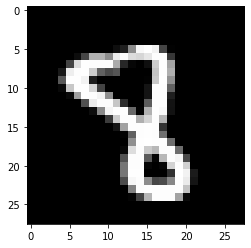

In [ ]:
ds = tfds.load('mnist', data_dir=DATA_DIR, shuffle_files=True) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

# Looping through the iterator, each batch is a dict
for batch in train_ds:
    # The first dimension in the shape is the batch dimension
    # The second and third dimensions are height and width
    # Being greyscale means that the image has one channel, the last dimension in the shape
    print("data shape:", batch['image'].shape)
    print("label:", batch['label'])
    break

# visualize some of the data
idx = np.random.randint(batch['image'].shape[0])
print("An image looks like this:")
imgplot = plt.imshow(batch['image'][idx][:,:,0], cmap='gray')
print("It's colored because matplotlib wants to provide more contrast than just greys")

#### Dense layers

The first step to building a simple neural network is to specify layers. The most basic building block is the dense layer (AKA linear layer or fully connected layer), so we'll declare a function that creates the layer. Each dense layer is composed of two variables, the weight matrix `W` and the bias vector `b` as well as a non-linear activation function `a`, to calculate the function `f(x) = a(Wx + b)`.

Normally we'll use pre-defined layers, but in this notebook we'll do it ourselves first to better understand what's going on under the hood.

In [ ]:
class Dense(tf.Module):
    def __init__(self, output_size, activation=tf.nn.relu):
        """
        Args:
            - output_size: (int) number of neurons
            - activation: (function) non-linear function applied to the output
        """
        self.output_size = output_size
        self.activation = activation
        self.is_built = False
        
    def _build(self, x):
        data_size = x.shape[-1]
        self.W = tf.Variable(tf.random.normal([data_size, self.output_size]), name='weights')
        self.b = tf.Variable(tf.random.normal([self.output_size]), name='bias')
        self.is_built = True

    def __call__(self, x):
        if not self.is_built:
            self._build(x)
        return self.activation(tf.matmul(x, self.W) + self.b)

The first dimension of the input is the "batch" dimension, which allows us to run many data through the model simultaneously. The matrix `W` has a row for each input dimension so that each column corresponds to the weights of one linear unit of the layer. After adding the bias vector to the vector resulting from the vector-matrix multiplication, we activate with a non-linearity.

Let's define a simple, two layer network with this function. We activate the first layer with the rectified linear function [`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu), but not the second layer so that we can interpret its output as the [logits](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow) of a discrete probability distribution. Note that we're going to flatten the data into a vector (784 = 28 x 28) so that we can use it with a linear layer (we encountered `tf.reshape` in the last hackathon). Loss is calculated with [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy), which implies that we're interpreting the output of the neural network as the paramters of a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution).

Further, we'll train with minibatches of data with the for loop (using tqdm for a progress bar). We run the data forward in each minibatch, calculate the loss using the output logits and correct label, calculate gradients, and finally backprop gradients using the 

100%|██████████| 1875/1875 [00:40<00:00, 45.76it/s] 


Accuracy: 0.037583333


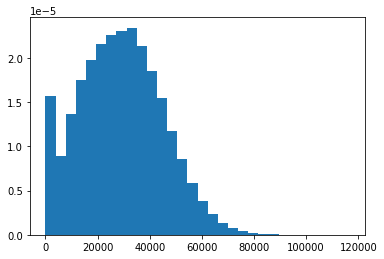

In [ ]:
first_layer = Dense(200)
second_layer = Dense(10)

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for batch in tqdm(train_ds):
    # run network
    x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784]) # -1 means everyting not otherwise accounted for
    labels = batch['label']
    x = first_layer(x)
    logits = second_layer(x)
    
    # calculate loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss_values.append(loss)
    
    # calculate accuracy
    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    accuracy_values.append(accuracy)

# print accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

#### Training by minibatch/gradient step and epoch

Now let's re-declare the network with pre-defined layers using [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), group the layers using [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), and training the parameters with the [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer.

Note how [`tf.GradientTape`](https://www.tensorflow.org/guide/autodiff) is used. We run all the computations which we want to backpropagate gradients through in the scope of the tape and then, after the loss is calculated, we can call `tape.gradient` to calculate the gradient of the output with respect to the model variables.

100%|██████████| 1875/1875 [00:22<00:00, 84.99it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 200)                 157000    
                                                                 
 dense_1 (Dense)             (32, 10)                  2010      
                                                                 
Total params: 159,010


Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 0.88575


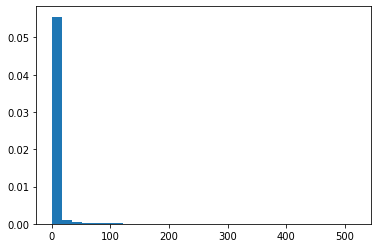

In [ ]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for epoch in range(1):
    for batch in tqdm(train_ds):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
            labels = batch['label']
            logits = model(x)

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
        loss_values.append(loss)
    
        # gradient update
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        accuracy_values.append(accuracy)

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

#### Splitting the dataset into train/validation

After one epoch of training the loss values drop dramatically and accuracy rises from change (\~10%) to that of a decent classifier (\~85-90%). In practice we want to train for many epochs and use the set of parameters which gives the lowest validation error. Unfortunately, we don't know which set of parameters is best because we're training on all the data. Before training, we should split the training dataset into a train set, which will be used for parameter updates, and a validation set, which will not. Then, we can determine which parameters generalise best by calculating the accuracy on the hold-out validation set. The parameters with the highest accuracy on validation will likely generalise the best.

The easiest way to do this is with TensorFlow Datasets is to use their string indexing notation when loading the datasets.

In [ ]:
# The first 90% of the training data
from tensorflow.keras.datasets import mnist

# Use this data for the training loop
train = tfds.load('mnist', split='train[:90%]', data_dir=DATA_DIR)

# And the last 10%, we'll hold out as the validation set
# Notice the python-style indexing, but in a string and with percentages
# After the training loop, run another loop over this data without the gradient updates to calculate accuracy
validation = tfds.load('mnist', split='train[-10%:]', data_dir=DATA_DIR)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ./tensorflow-datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
print(train)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [ ]:
# trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
train_images = train.map(lambda image: tf.reshape(image['image'],[28, 28, 1]))
train['image'] = train_images
print(train)

TypeError: ignored

### Homework

Your homework is to specify a network with `tf.keras.layers`, train it on the MNIST dataset (as above, but with train/validation split), and try out 2 or 3 variations of different architectures. I.e., change the number of neurons or layers, change the activation function (you can find more in the documentation at [`tf.nn`](https://www.tensorflow.org/api_docs/python/tf/nn)), or even change the optimizer ([`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)). Write up a paragraph or two with your observations. E.g., how did it affect the final accuracy on the validation data? How did it affect the rate at which the model improved? Remember to add early stopping and increase the number of training epochs. Submit a `.pdf` with the writeup and `.py` with the code.

I'm expecting this to take about an hour (or less if you're experienced). Feel free to use any code from this or previous hackathons. If you don't understand how to do any part of this or if it's taking you longer than that, please let me know in office hours or by email (both can be found on the syllabus). I'm also happy to discuss if you just want to ask more questions about anything in this notebook!


<h1>My responses </h1>
In terms of how the model is affected by different parmaeters we have a few things to consider. I ran three experiments that I decided to write up. The first was a simple archetecture with a dense layers with a leaky relu activation function with 200 neurons and a final with 10 for each char. A second with the same number of layers but a leaky relu instead of a normal one, finally one with four layers with 74, 200, 500, and 500 neurons respectively.   
<h1>Activation function </h1>
I tried leaky relu instead of relu with the same archetecture othewise, this actually offered an improvement 0.95633334 vs 0.94016665. After discovering this I did a bit of research and this is consistant with other people's observations https://towardsdatascience.com/leaky-relu-vs-relu-activation-functions-which-is-better-1a1533d0a89f  
<h1>number of neurons & number of layers </h1> 
For the nubmer of neurons and number of layers, I created an experiment that increased the number of layers and the number of layers. This increased my performance to 0.959 however there was also a slight increase in runtime. This is consistant with my previous knowledge that increasing the complexity will alow us to pick up on more complex patterns. 

The results of my experiment can be seen below 

In [ ]:
#@title
def calculateAccuracy(model,test_ds ):
  accuracy_values = []
  for batch in tqdm(test_ds):
    with tf.GradientTape() as tape:
      # run network
      x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
      labels = batch['label']
      logits = model(x)
      # calculate accuracy
      predictions = tf.argmax(logits, axis=1)
      accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
      accuracy_values.append(accuracy)
  return np.mean(accuracy_values)

In [ ]:
import time

In [ ]:
#@title
def trainModel(model, train_ds, epochs):
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
  val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
  @tf.function
  def train_step(batch):
    with tf.GradientTape() as tape:
      # run network
      x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
      labels = batch['label']
      logits = model(x)
      # calculate loss
      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_acc_metric.update_state(labels, logits)
    train_loss_metric.update_state(labels, logits)
    return loss
  @tf.function    
  def test_step(batch):
    x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
    labels = batch['label']
    logits = model(x, training=False)
    val_acc_metric.update_state(labels, logits)
    val_loss_metric.update_state(labels, logits)
  patience = 5
  wait = 0
  best = float('inf')
  train_ds = train.shuffle(1024).batch(32)
  loss_values = []
  accuracy_values = []
  for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))
      start_time = time.time()
      for batch in tqdm(train_ds):
          loss = train_step(batch)
          loss_values.append(loss)
      train_acc = train_acc_metric.result()
      train_loss = train_loss_metric.result()
      train_acc_metric.reset_states()
      train_loss_metric.reset_states()
      print("Training acc over epoch: %.4f" % (train_acc.numpy()))
      for batch in tqdm(validation):
        test_step(batch)
      val_acc = val_acc_metric.result()
      val_loss = val_loss_metric.result()
      val_acc_metric.reset_states()
      val_loss_metric.reset_states()
      print("Validation acc: %.4f" % (float(val_acc),))
      print("Time taken: %.2fs" % (time.time() - start_time))
      print("wait, val_lost and best", wait, val_loss, best)
      wait += 1
      if val_loss < best:
        best = val_loss
        wait = 0
      if wait >= patience:
        print("get stopped")
        break

  print(model.summary())
      
  # accuracy
  print("Accuracy:", np.mean(accuracy_values))
  print("Test Accuracy:", val_acc)
  # plot per-datum loss
  loss_values = np.concatenate(loss_values)
  plt.hist(loss_values, density=True, bins=30)
  plt.show()


Start of epoch 0


100%|██████████| 1688/1688 [00:03<00:00, 526.18it/s]


Training acc over epoch: 0.8821


100%|██████████| 6000/6000 [00:07<00:00, 842.85it/s]


Validation acc: 0.9073
Time taken: 10.35s
wait, val_lost and best 0 tf.Tensor(1.8171194, shape=(), dtype=float32) inf

Start of epoch 1


100%|██████████| 1688/1688 [00:02<00:00, 602.47it/s]


Training acc over epoch: 0.9225


100%|██████████| 6000/6000 [00:07<00:00, 846.08it/s]


Validation acc: 0.9300
Time taken: 9.91s
wait, val_lost and best 0 tf.Tensor(1.9323231, shape=(), dtype=float32) tf.Tensor(1.8171194, shape=(), dtype=float32)

Start of epoch 2


100%|██████████| 1688/1688 [00:02<00:00, 597.17it/s]


Training acc over epoch: 0.9344


100%|██████████| 6000/6000 [00:07<00:00, 841.28it/s]


Validation acc: 0.9402
Time taken: 9.98s
wait, val_lost and best 1 tf.Tensor(1.9493332, shape=(), dtype=float32) tf.Tensor(1.8171194, shape=(), dtype=float32)

Start of epoch 3


100%|██████████| 1688/1688 [00:02<00:00, 594.15it/s]


Training acc over epoch: 0.9402


100%|██████████| 6000/6000 [00:07<00:00, 841.12it/s]


Validation acc: 0.9342
Time taken: 10.00s
wait, val_lost and best 2 tf.Tensor(1.991806, shape=(), dtype=float32) tf.Tensor(1.8171194, shape=(), dtype=float32)

Start of epoch 4


100%|██████████| 1688/1688 [00:02<00:00, 616.49it/s]


Training acc over epoch: 0.9450


100%|██████████| 6000/6000 [00:07<00:00, 818.29it/s]


Validation acc: 0.9470
Time taken: 10.09s
wait, val_lost and best 3 tf.Tensor(1.9560394, shape=(), dtype=float32) tf.Tensor(1.8171194, shape=(), dtype=float32)

Start of epoch 5


100%|██████████| 1688/1688 [00:02<00:00, 585.69it/s]


Training acc over epoch: 0.9476


100%|██████████| 6000/6000 [00:07<00:00, 845.43it/s]

Validation acc: 0.9402
Time taken: 10.00s
wait, val_lost and best 4 tf.Tensor(1.8861351, shape=(), dtype=float32) tf.Tensor(1.8171194, shape=(), dtype=float32)
get stopped
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 200)               157000    
                                                                 
 dense_46 (Dense)            (None, 10)                2010      


                                                                 
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: nan
Test Accuracy: tf.Tensor(0.94016665, shape=(), dtype=float32)


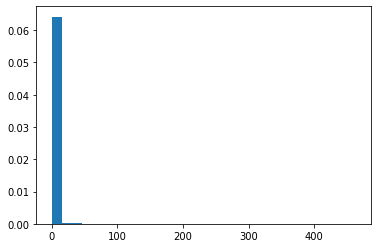

In [ ]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()
trainModel(model, train,10)


Start of epoch 0


100%|██████████| 1688/1688 [00:05<00:00, 329.91it/s]


Training acc over epoch: 0.8844


100%|██████████| 6000/6000 [00:07<00:00, 856.32it/s]


Validation acc: 0.9098
Time taken: 12.15s
wait, val_lost and best 0 tf.Tensor(1.7386309, shape=(), dtype=float32) inf

Start of epoch 1


100%|██████████| 1688/1688 [00:02<00:00, 589.02it/s]


Training acc over epoch: 0.9258


100%|██████████| 6000/6000 [00:06<00:00, 868.59it/s]


Validation acc: 0.9353
Time taken: 9.80s
wait, val_lost and best 0 tf.Tensor(1.7407221, shape=(), dtype=float32) tf.Tensor(1.7386309, shape=(), dtype=float32)

Start of epoch 2


100%|██████████| 1688/1688 [00:02<00:00, 591.49it/s]


Training acc over epoch: 0.9405


100%|██████████| 6000/6000 [00:07<00:00, 849.71it/s]


Validation acc: 0.9387
Time taken: 9.94s
wait, val_lost and best 1 tf.Tensor(1.6415809, shape=(), dtype=float32) tf.Tensor(1.7386309, shape=(), dtype=float32)

Start of epoch 3


100%|██████████| 1688/1688 [00:02<00:00, 609.79it/s]


Training acc over epoch: 0.9500


100%|██████████| 6000/6000 [00:06<00:00, 857.47it/s]


Validation acc: 0.9535
Time taken: 9.79s
wait, val_lost and best 0 tf.Tensor(1.5240695, shape=(), dtype=float32) tf.Tensor(1.6415809, shape=(), dtype=float32)

Start of epoch 4


100%|██████████| 1688/1688 [00:02<00:00, 600.55it/s]


Training acc over epoch: 0.9557


100%|██████████| 6000/6000 [00:07<00:00, 847.45it/s]


Validation acc: 0.9500
Time taken: 9.92s
wait, val_lost and best 0 tf.Tensor(1.6058493, shape=(), dtype=float32) tf.Tensor(1.5240695, shape=(), dtype=float32)

Start of epoch 5


100%|██████████| 1688/1688 [00:04<00:00, 385.65it/s]


Training acc over epoch: 0.9584


100%|██████████| 6000/6000 [00:07<00:00, 849.00it/s]


Validation acc: 0.9577
Time taken: 11.47s
wait, val_lost and best 1 tf.Tensor(1.6519735, shape=(), dtype=float32) tf.Tensor(1.5240695, shape=(), dtype=float32)

Start of epoch 6


100%|██████████| 1688/1688 [00:05<00:00, 330.85it/s]


Training acc over epoch: 0.9636


100%|██████████| 6000/6000 [00:07<00:00, 856.16it/s]


Validation acc: 0.9585
Time taken: 12.14s
wait, val_lost and best 2 tf.Tensor(1.5723743, shape=(), dtype=float32) tf.Tensor(1.5240695, shape=(), dtype=float32)

Start of epoch 7


100%|██████████| 1688/1688 [00:02<00:00, 589.70it/s]


Training acc over epoch: 0.9658


100%|██████████| 6000/6000 [00:07<00:00, 851.09it/s]


Validation acc: 0.9550
Time taken: 9.95s
wait, val_lost and best 3 tf.Tensor(1.5230032, shape=(), dtype=float32) tf.Tensor(1.5240695, shape=(), dtype=float32)

Start of epoch 8


100%|██████████| 1688/1688 [00:02<00:00, 589.40it/s]


Training acc over epoch: 0.9694


100%|██████████| 6000/6000 [00:06<00:00, 857.17it/s]


Validation acc: 0.9573
Time taken: 9.89s
wait, val_lost and best 0 tf.Tensor(1.6234113, shape=(), dtype=float32) tf.Tensor(1.5230032, shape=(), dtype=float32)

Start of epoch 9


100%|██████████| 1688/1688 [00:02<00:00, 592.69it/s]


Training acc over epoch: 0.9717


100%|██████████| 6000/6000 [00:07<00:00, 846.77it/s]

Validation acc: 0.9563
Time taken: 9.96s
wait, val_lost and best 1 tf.Tensor(1.6382258, shape=(), dtype=float32) tf.Tensor(1.5230032, shape=(), dtype=float32)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 200)               157000    
                                                                 
 dense_48 (Dense)            (None, 10)                2010      
                                                                 
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________


None
Accuracy: nan
Test Accuracy: tf.Tensor(0.95633334, shape=(), dtype=float32)


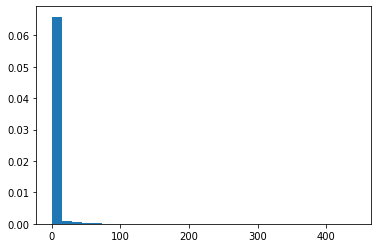

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, LeakyReLU(alpha=0.1)))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()
trainModel(model, train,10)


Start of epoch 0


100%|██████████| 1688/1688 [00:04<00:00, 421.97it/s]


Training acc over epoch: 0.8806


100%|██████████| 6000/6000 [00:08<00:00, 747.71it/s]


Validation acc: 0.9388
Time taken: 12.05s
wait, val_lost and best 0 tf.Tensor(1.2909501, shape=(), dtype=float32) inf

Start of epoch 1


100%|██████████| 1688/1688 [00:03<00:00, 484.01it/s]


Training acc over epoch: 0.9420


100%|██████████| 6000/6000 [00:07<00:00, 756.80it/s]


Validation acc: 0.9457
Time taken: 11.44s
wait, val_lost and best 0 tf.Tensor(1.4756607, shape=(), dtype=float32) tf.Tensor(1.2909501, shape=(), dtype=float32)

Start of epoch 2


100%|██████████| 1688/1688 [00:05<00:00, 330.46it/s]


Training acc over epoch: 0.9547


100%|██████████| 6000/6000 [00:08<00:00, 720.67it/s]


Validation acc: 0.9497
Time taken: 13.46s
wait, val_lost and best 1 tf.Tensor(1.4892992, shape=(), dtype=float32) tf.Tensor(1.2909501, shape=(), dtype=float32)

Start of epoch 3


100%|██████████| 1688/1688 [00:03<00:00, 474.19it/s]


Training acc over epoch: 0.9604


100%|██████████| 6000/6000 [00:08<00:00, 721.25it/s]


Validation acc: 0.9618
Time taken: 11.91s
wait, val_lost and best 2 tf.Tensor(1.434958, shape=(), dtype=float32) tf.Tensor(1.2909501, shape=(), dtype=float32)

Start of epoch 4


100%|██████████| 1688/1688 [00:03<00:00, 469.01it/s]


Training acc over epoch: 0.9654


100%|██████████| 6000/6000 [00:08<00:00, 728.16it/s]


Validation acc: 0.9558
Time taken: 11.87s
wait, val_lost and best 3 tf.Tensor(1.3800597, shape=(), dtype=float32) tf.Tensor(1.2909501, shape=(), dtype=float32)

Start of epoch 5


100%|██████████| 1688/1688 [00:03<00:00, 469.92it/s]


Training acc over epoch: 0.9696


100%|██████████| 6000/6000 [00:08<00:00, 736.28it/s]

Validation acc: 0.9590
Time taken: 11.77s
wait, val_lost and best 4 tf.Tensor(1.3979286, shape=(), dtype=float32) tf.Tensor(1.2909501, shape=(), dtype=float32)
get stopped
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 74)                58090     
                                                                 
 dense_73 (Dense)            (None, 200)               15000     
                                                                 
 dense_74 (Dense)            (None, 500)               100500    
                                                                 
 dense_75 (Dense)            (None, 500)               250500    
                                                                 
 dense_76 (Dense)            (None, 10)                5010      
                                                                 
Total params:

None
Accuracy: nan
Test Accuracy: tf.Tensor(0.959, shape=(), dtype=float32)


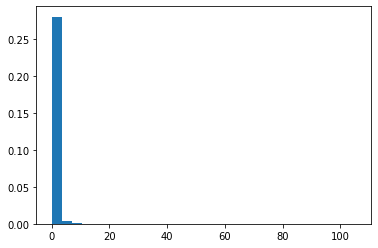

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(74, tf.nn.relu))
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(500, tf.nn.relu))
model.add(tf.keras.layers.Dense(500, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()
trainModel(model, train,10)

In [ ]:
from keras.layers import LeakyReLU
import keras


In [ ]:
#@title
def trainModel(model, train_ds):
  train_ds = train.shuffle(1024).batch(32)
  loss_values = []
  accuracy_values = []
  # Loop through one epoch of data
  for epoch in range(1):
      for batch in tqdm(train_ds):
          with tf.GradientTape() as tape:
              # run network
              x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
              labels = batch['label']
              # x = tf.cast(batch, tf.float32).map(lambda image: tf.reshape(image['image'],[28, 28, 1]))
              logits = model(x)

              # calculate loss
              loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
          loss_values.append(loss)
      
          # gradient update
          grads = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
          # calculate accuracy
          predictions = tf.argmax(logits, axis=1)
          accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
          accuracy_values.append(accuracy)


  print(model.summary())
      
  # accuracy
  print("Accuracy:", np.mean(accuracy_values))
  print("Test Accuracy:", calculateAccuracy(model,validation))
  # plot per-datum loss
  loss_values = np.concatenate(loss_values)
  plt.hist(loss_values, density=True, bins=30)
  plt.show()
model = tf.keras.Sequential()
# x_train =train.reshape((train.shape[0], 28, 28, 1))
# model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()
trainModel(model, train)

  0%|          | 7/1688 [00:00<01:01, 27.35it/s]

Training acc over epoch: 0.1250
Training acc over epoch: 0.0312
Training acc over epoch: 0.1250
Training acc over epoch: 0.0938
Training acc over epoch: 0.2188
Training acc over epoch: 0.1562
Training acc over epoch: 0.0312
Training acc over epoch: 0.2188
Training acc over epoch: 0.2188
Training acc over epoch: 0.1875
Training acc over epoch: 0.2812
Training acc over epoch: 0.2812
Training acc over epoch: 0.2500
Training acc over epoch: 0.2500


  1%|▏         | 22/1688 [00:00<00:31, 52.42it/s]

Training acc over epoch: 0.4688
Training acc over epoch: 0.4062
Training acc over epoch: 0.3438
Training acc over epoch: 0.3438
Training acc over epoch: 0.3438
Training acc over epoch: 0.2812
Training acc over epoch: 0.5625
Training acc over epoch: 0.3750
Training acc over epoch: 0.3125
Training acc over epoch: 0.5625
Training acc over epoch: 0.5938
Training acc over epoch: 0.3438
Training acc over epoch: 0.4062


  2%|▏         | 34/1688 [00:00<00:31, 52.27it/s]

Training acc over epoch: 0.4688
Training acc over epoch: 0.4688
Training acc over epoch: 0.5312
Training acc over epoch: 0.5312
Training acc over epoch: 0.7500
Training acc over epoch: 0.5000
Training acc over epoch: 0.4688
Training acc over epoch: 0.4062
Training acc over epoch: 0.4062
Training acc over epoch: 0.6562
Training acc over epoch: 0.6250
Training acc over epoch: 0.5312


  3%|▎         | 48/1688 [00:00<00:28, 58.53it/s]

Training acc over epoch: 0.6562
Training acc over epoch: 0.5312
Training acc over epoch: 0.6562
Training acc over epoch: 0.6562
Training acc over epoch: 0.5625
Training acc over epoch: 0.6562
Training acc over epoch: 0.6250
Training acc over epoch: 0.7500
Training acc over epoch: 0.6875
Training acc over epoch: 0.6562
Training acc over epoch: 0.5625
Training acc over epoch: 0.6250


  4%|▎         | 63/1688 [00:01<00:26, 62.48it/s]

Training acc over epoch: 0.4375
Training acc over epoch: 0.6875
Training acc over epoch: 0.7500
Training acc over epoch: 0.5312
Training acc over epoch: 0.8125
Training acc over epoch: 0.6562
Training acc over epoch: 0.7188
Training acc over epoch: 0.5938
Training acc over epoch: 0.7500
Training acc over epoch: 0.6875
Training acc over epoch: 0.5938
Training acc over epoch: 0.6875
Training acc over epoch: 0.6562
Training acc over epoch: 0.7812
Training acc over epoch: 0.5312


  5%|▍         | 78/1688 [00:01<00:23, 67.47it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.7500
Training acc over epoch: 0.7188
Training acc over epoch: 0.6875
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.6875
Training acc over epoch: 0.5938
Training acc over epoch: 0.7500
Training acc over epoch: 0.6562
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.6875
Training acc over epoch: 0.6562


  6%|▌         | 93/1688 [00:01<00:23, 69.13it/s]

Training acc over epoch: 0.6250
Training acc over epoch: 0.7500
Training acc over epoch: 0.6250
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.5625
Training acc over epoch: 0.7188
Training acc over epoch: 0.7188
Training acc over epoch: 0.8125
Training acc over epoch: 0.6250
Training acc over epoch: 0.7812
Training acc over epoch: 0.5938
Training acc over epoch: 0.6562
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812


  6%|▋         | 109/1688 [00:01<00:21, 72.17it/s]

Training acc over epoch: 0.7500
Training acc over epoch: 0.6875
Training acc over epoch: 0.5938
Training acc over epoch: 0.7500
Training acc over epoch: 0.6562
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.6875
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.6562
Training acc over epoch: 0.7812


  7%|▋         | 125/1688 [00:02<00:21, 71.13it/s]

Training acc over epoch: 0.5938
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.6875
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7188
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500


  8%|▊         | 141/1688 [00:02<00:21, 72.91it/s]

Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.6562
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.5312
Training acc over epoch: 0.8438
Training acc over epoch: 0.6875
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.6562
Training acc over epoch: 0.7500


  9%|▉         | 157/1688 [00:02<00:20, 74.71it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.6875
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.5938


 10%|█         | 173/1688 [00:02<00:20, 73.00it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.6875


 11%|█         | 189/1688 [00:02<00:20, 73.46it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.6250
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500


 12%|█▏        | 197/1688 [00:03<00:22, 67.54it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.6875
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 13%|█▎        | 212/1688 [00:03<00:21, 69.63it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375


 13%|█▎        | 227/1688 [00:03<00:21, 67.08it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.7188
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438


 14%|█▍        | 241/1688 [00:03<00:22, 64.73it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9688
Training acc over epoch: 0.7188
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125


 15%|█▌        | 255/1688 [00:03<00:23, 61.52it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.6875
Training acc over epoch: 0.6875
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438


 16%|█▌        | 269/1688 [00:04<00:23, 60.25it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.6562
Training acc over epoch: 0.6875


 17%|█▋        | 283/1688 [00:04<00:22, 61.59it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375


 18%|█▊        | 298/1688 [00:04<00:20, 66.76it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 18%|█▊        | 312/1688 [00:04<00:20, 67.32it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438


 19%|█▉        | 327/1688 [00:05<00:20, 67.24it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500


 20%|██        | 342/1688 [00:05<00:19, 67.68it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750


 21%|██        | 357/1688 [00:05<00:19, 68.19it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750


 22%|██▏       | 373/1688 [00:05<00:18, 70.81it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375


 23%|██▎       | 381/1688 [00:05<00:19, 68.51it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125


 24%|██▎       | 397/1688 [00:06<00:18, 69.17it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812


 24%|██▍       | 412/1688 [00:06<00:18, 68.66it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.6875
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.6875
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438


 25%|██▌       | 428/1688 [00:06<00:17, 71.23it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.6875
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750


 26%|██▋       | 444/1688 [00:06<00:16, 73.85it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.6250
Training acc over epoch: 0.8125


 27%|██▋       | 460/1688 [00:06<00:16, 74.32it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 28%|██▊       | 476/1688 [00:07<00:17, 69.34it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500

 29%|██▉       | 491/1688 [00:07<00:17, 70.13it/s]


Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 30%|██▉       | 506/1688 [00:07<00:18, 63.94it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438


 31%|███       | 521/1688 [00:07<00:16, 68.90it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.7188
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375


 32%|███▏      | 536/1688 [00:08<00:16, 68.54it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 33%|███▎      | 551/1688 [00:08<00:16, 69.75it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 34%|███▎      | 567/1688 [00:08<00:15, 71.89it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688


 35%|███▍      | 583/1688 [00:08<00:15, 73.46it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062


 36%|███▌      | 600/1688 [00:08<00:14, 76.65it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.6875
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375


 36%|███▋      | 616/1688 [00:09<00:14, 74.94it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 37%|███▋      | 624/1688 [00:09<00:14, 72.59it/s]

Training acc over epoch: 0.6562
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.6250
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375


 38%|███▊      | 640/1688 [00:09<00:14, 71.36it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 39%|███▉      | 656/1688 [00:09<00:14, 69.72it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 40%|███▉      | 671/1688 [00:09<00:14, 70.45it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7188


 41%|████      | 687/1688 [00:10<00:14, 69.85it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125


 42%|████▏     | 703/1688 [00:10<00:14, 70.12it/s]

Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688


 43%|████▎     | 719/1688 [00:10<00:14, 68.43it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.6562
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 44%|████▎     | 735/1688 [00:10<00:13, 70.86it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 44%|████▍     | 751/1688 [00:11<00:13, 72.01it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.6875
Training acc over epoch: 0.8125
Training acc over epoch: 0.6875
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812


 45%|████▍     | 759/1688 [00:11<00:12, 72.73it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 46%|████▌     | 775/1688 [00:11<00:12, 71.62it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812


 47%|████▋     | 791/1688 [00:11<00:12, 70.37it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750


 48%|████▊     | 807/1688 [00:11<00:12, 69.54it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812


 49%|████▉     | 823/1688 [00:12<00:12, 68.69it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 50%|████▉     | 837/1688 [00:12<00:12, 67.42it/s]

Training acc over epoch: 0.6875
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.6875
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.6562
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125


 50%|█████     | 851/1688 [00:12<00:12, 67.98it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438


 51%|█████     | 865/1688 [00:12<00:12, 66.76it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 52%|█████▏    | 881/1688 [00:13<00:11, 72.09it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750


 53%|█████▎    | 897/1688 [00:13<00:10, 72.00it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 54%|█████▍    | 913/1688 [00:13<00:10, 71.03it/s]

Training acc over epoch: 0.6875
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 55%|█████▌    | 929/1688 [00:13<00:10, 71.59it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 56%|█████▌    | 945/1688 [00:13<00:10, 73.40it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500


 57%|█████▋    | 961/1688 [00:14<00:09, 74.42it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.6875
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 57%|█████▋    | 969/1688 [00:14<00:10, 66.35it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.6875
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 58%|█████▊    | 984/1688 [00:14<00:10, 67.09it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438

 59%|█████▉    | 998/1688 [00:14<00:10, 65.87it/s]


Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 60%|█████▉    | 1012/1688 [00:14<00:10, 65.63it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125


 61%|██████    | 1027/1688 [00:15<00:09, 67.74it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750


 62%|██████▏   | 1042/1688 [00:15<00:09, 68.42it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688


 63%|██████▎   | 1057/1688 [00:15<00:09, 68.57it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 64%|██████▎   | 1072/1688 [00:15<00:08, 70.01it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7188
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750


 64%|██████▍   | 1088/1688 [00:15<00:08, 72.84it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 65%|██████▌   | 1103/1688 [00:16<00:08, 66.32it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 66%|██████▌   | 1118/1688 [00:16<00:08, 68.41it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 67%|██████▋   | 1132/1688 [00:16<00:08, 66.93it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.6875
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 68%|██████▊   | 1147/1688 [00:16<00:07, 67.92it/s]

Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750


 69%|██████▉   | 1163/1688 [00:17<00:07, 70.53it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750


 69%|██████▉   | 1171/1688 [00:17<00:07, 68.76it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750


 70%|███████   | 1186/1688 [00:17<00:07, 67.66it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 71%|███████   | 1201/1688 [00:17<00:07, 66.57it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062


 72%|███████▏  | 1216/1688 [00:17<00:07, 64.93it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062

 73%|███████▎  | 1232/1688 [00:18<00:06, 70.03it/s]


Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500


 74%|███████▍  | 1248/1688 [00:18<00:06, 72.53it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 75%|███████▍  | 1264/1688 [00:18<00:05, 74.33it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188


 76%|███████▌  | 1280/1688 [00:18<00:05, 72.47it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688


 77%|███████▋  | 1296/1688 [00:19<00:05, 69.00it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.6250
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.6562
Training acc over epoch: 0.8125


 78%|███████▊  | 1310/1688 [00:19<00:05, 65.51it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688


 78%|███████▊  | 1325/1688 [00:19<00:05, 68.42it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750


 79%|███████▉  | 1332/1688 [00:19<00:05, 65.39it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375


 80%|███████▉  | 1346/1688 [00:19<00:05, 60.97it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750


 81%|████████  | 1360/1688 [00:20<00:05, 62.22it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 81%|████████▏ | 1375/1688 [00:20<00:04, 67.46it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 82%|████████▏ | 1390/1688 [00:20<00:04, 69.27it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812


 83%|████████▎ | 1405/1688 [00:20<00:04, 69.97it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375

 84%|████████▍ | 1422/1688 [00:20<00:03, 76.37it/s]


Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125

 85%|████████▌ | 1438/1688 [00:21<00:03, 75.78it/s]


Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 86%|████████▌ | 1454/1688 [00:21<00:03, 73.53it/s]

Training acc over epoch: 0.7500
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062


 87%|████████▋ | 1470/1688 [00:21<00:03, 72.63it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750


 88%|████████▊ | 1485/1688 [00:21<00:02, 69.35it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.9688
Training acc over epoch: 0.7188
Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125


 89%|████████▉ | 1500/1688 [00:21<00:02, 70.45it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 90%|████████▉ | 1516/1688 [00:22<00:02, 72.20it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125


 90%|█████████ | 1524/1688 [00:22<00:02, 69.99it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375


 91%|█████████▏| 1542/1688 [00:22<00:01, 75.64it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 92%|█████████▏| 1558/1688 [00:22<00:01, 74.51it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.6875
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 93%|█████████▎| 1575/1688 [00:22<00:01, 77.05it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375


 94%|█████████▍| 1591/1688 [00:23<00:01, 72.02it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375


 95%|█████████▌| 1607/1688 [00:23<00:01, 73.20it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 96%|█████████▌| 1623/1688 [00:23<00:00, 69.46it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 97%|█████████▋| 1638/1688 [00:23<00:00, 69.07it/s]

Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 98%|█████████▊| 1654/1688 [00:24<00:00, 72.41it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375


 99%|█████████▉| 1672/1688 [00:24<00:00, 79.63it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125


100%|█████████▉| 1682/1688 [00:24<00:00, 84.72it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125


  1%|          | 15/1688 [00:00<00:23, 70.98it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


  2%|▏         | 31/1688 [00:00<00:22, 73.07it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062


  3%|▎         | 48/1688 [00:00<00:21, 75.90it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


  4%|▍         | 65/1688 [00:00<00:20, 78.83it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375


  5%|▍         | 81/1688 [00:01<00:20, 78.14it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438


  6%|▌         | 98/1688 [00:01<00:19, 80.55it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.7500


  7%|▋         | 117/1688 [00:01<00:18, 85.70it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125

  8%|▊         | 136/1688 [00:01<00:17, 87.60it/s]


Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


  9%|▉         | 155/1688 [00:01<00:17, 88.21it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.7188


 10%|█         | 173/1688 [00:02<00:17, 84.58it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 11%|█▏        | 191/1688 [00:02<00:18, 82.58it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 12%|█▏        | 209/1688 [00:02<00:18, 81.89it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375

 13%|█▎        | 218/1688 [00:02<00:18, 80.29it/s]


Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812

 14%|█▍        | 236/1688 [00:02<00:18, 79.79it/s]


Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438


 15%|█▍        | 252/1688 [00:03<00:19, 73.87it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750

 16%|█▌        | 268/1688 [00:03<00:19, 74.43it/s]


Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 17%|█▋        | 285/1688 [00:03<00:18, 77.39it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 18%|█▊        | 303/1688 [00:03<00:16, 82.45it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 19%|█▉        | 321/1688 [00:04<00:16, 84.62it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812


 20%|██        | 339/1688 [00:04<00:16, 83.12it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750


 21%|██        | 358/1688 [00:04<00:15, 87.15it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 22%|██▏       | 376/1688 [00:04<00:15, 82.37it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688


 23%|██▎       | 394/1688 [00:04<00:16, 80.67it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 1.0000
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125


 24%|██▍       | 412/1688 [00:05<00:15, 83.43it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 25%|██▌       | 430/1688 [00:05<00:15, 81.20it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375


 27%|██▋       | 448/1688 [00:05<00:14, 82.75it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 1.0000
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438


 27%|██▋       | 457/1688 [00:05<00:15, 80.38it/s]

Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062


 28%|██▊       | 475/1688 [00:05<00:14, 81.01it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062

 29%|██▉       | 493/1688 [00:06<00:14, 83.88it/s]


Training acc over epoch: 1.0000
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062


 30%|██▉       | 502/1688 [00:06<00:24, 48.01it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 30%|███       | 509/1688 [00:06<00:33, 35.60it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062


 31%|███       | 515/1688 [00:07<00:41, 28.51it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 31%|███       | 526/1688 [00:07<00:39, 29.63it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7188


 32%|███▏      | 543/1688 [00:07<00:24, 46.83it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125


 33%|███▎      | 560/1688 [00:07<00:18, 59.71it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 34%|███▍      | 576/1688 [00:08<00:16, 65.54it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 35%|███▌      | 592/1688 [00:08<00:16, 68.47it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 36%|███▌      | 610/1688 [00:08<00:13, 77.25it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375


 37%|███▋      | 628/1688 [00:08<00:12, 82.36it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438


 38%|███▊      | 646/1688 [00:09<00:12, 85.40it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750


 39%|███▉      | 665/1688 [00:09<00:11, 88.29it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 41%|████      | 684/1688 [00:09<00:11, 88.47it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 42%|████▏     | 703/1688 [00:09<00:11, 88.67it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125


 43%|████▎     | 721/1688 [00:09<00:11, 87.66it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688


 44%|████▍     | 739/1688 [00:10<00:11, 84.21it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 44%|████▍     | 748/1688 [00:10<00:11, 82.45it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 45%|████▌     | 766/1688 [00:10<00:11, 79.24it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 46%|████▋     | 783/1688 [00:10<00:11, 80.09it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375


 47%|████▋     | 800/1688 [00:10<00:11, 77.31it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 48%|████▊     | 816/1688 [00:11<00:11, 76.88it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750


 49%|████▉     | 833/1688 [00:11<00:11, 77.25it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062


 50%|█████     | 852/1688 [00:11<00:10, 82.74it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 52%|█████▏    | 870/1688 [00:11<00:09, 85.01it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 53%|█████▎    | 888/1688 [00:11<00:09, 86.46it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375


 54%|█████▎    | 906/1688 [00:12<00:09, 85.43it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375


 55%|█████▍    | 924/1688 [00:12<00:09, 81.37it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 56%|█████▌    | 942/1688 [00:12<00:09, 80.34it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188


 57%|█████▋    | 961/1688 [00:12<00:08, 83.92it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812


 58%|█████▊    | 979/1688 [00:13<00:08, 85.19it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125


 59%|█████▉    | 998/1688 [00:13<00:08, 85.60it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7188
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750


 60%|██████    | 1016/1688 [00:13<00:08, 82.35it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438

 61%|██████▏   | 1034/1688 [00:13<00:07, 83.11it/s]


Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 62%|██████▏   | 1053/1688 [00:13<00:07, 87.48it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 63%|██████▎   | 1071/1688 [00:14<00:07, 87.35it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062


 65%|██████▍   | 1089/1688 [00:14<00:06, 86.69it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000


 65%|██████▌   | 1098/1688 [00:14<00:07, 78.47it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125


 66%|██████▌   | 1115/1688 [00:14<00:07, 80.50it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 67%|██████▋   | 1133/1688 [00:14<00:06, 81.01it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062


 68%|██████▊   | 1151/1688 [00:15<00:06, 82.76it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 69%|██████▉   | 1170/1688 [00:15<00:06, 86.09it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.6875
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125


 70%|███████   | 1188/1688 [00:15<00:05, 84.12it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 71%|███████▏  | 1206/1688 [00:15<00:05, 83.94it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062

 73%|███████▎  | 1225/1688 [00:16<00:05, 89.10it/s]


Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375


 74%|███████▍  | 1245/1688 [00:16<00:04, 91.45it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750

 75%|███████▍  | 1265/1688 [00:16<00:04, 93.59it/s]


Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 76%|███████▌  | 1285/1688 [00:16<00:04, 91.03it/s]

Training acc over epoch: 1.0000
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438


 77%|███████▋  | 1305/1688 [00:16<00:04, 86.36it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125


 78%|███████▊  | 1323/1688 [00:17<00:04, 85.52it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 79%|███████▉  | 1332/1688 [00:17<00:04, 81.79it/s]

Training acc over epoch: 0.6875
Training acc over epoch: 1.0000
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438


 80%|███████▉  | 1350/1688 [00:17<00:04, 81.56it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 81%|████████  | 1367/1688 [00:17<00:04, 76.14it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750


 82%|████████▏ | 1384/1688 [00:17<00:03, 78.55it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125


 83%|████████▎ | 1401/1688 [00:18<00:03, 81.10it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 84%|████████▍ | 1419/1688 [00:18<00:03, 79.93it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125


 85%|████████▌ | 1437/1688 [00:18<00:03, 80.35it/s]

Training acc over epoch: 0.7188
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 86%|████████▋ | 1456/1688 [00:18<00:02, 83.97it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 87%|████████▋ | 1475/1688 [00:19<00:02, 86.57it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 88%|████████▊ | 1493/1688 [00:19<00:02, 84.32it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 90%|████████▉ | 1511/1688 [00:19<00:02, 85.02it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 91%|█████████ | 1529/1688 [00:19<00:02, 78.35it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125


 92%|█████████▏| 1546/1688 [00:19<00:01, 79.86it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750


 93%|█████████▎| 1564/1688 [00:20<00:01, 82.54it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 93%|█████████▎| 1573/1688 [00:20<00:01, 81.29it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750


 94%|█████████▍| 1591/1688 [00:20<00:01, 80.51it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375


 95%|█████████▌| 1608/1688 [00:20<00:01, 74.21it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 1.0000
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 96%|█████████▋| 1625/1688 [00:20<00:00, 75.82it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 97%|█████████▋| 1642/1688 [00:21<00:00, 79.66it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688


 98%|█████████▊| 1660/1688 [00:21<00:00, 80.91it/s]

Training acc over epoch: 0.6250
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 99%|█████████▉| 1678/1688 [00:21<00:00, 79.98it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750

100%|██████████| 1688/1688 [00:21<00:00, 77.64it/s]



Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125


  1%|          | 14/1688 [00:00<00:25, 65.49it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


  2%|▏         | 29/1688 [00:00<00:24, 67.78it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375


  3%|▎         | 44/1688 [00:00<00:23, 70.34it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438


  4%|▎         | 60/1688 [00:00<00:23, 69.89it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750


  4%|▍         | 75/1688 [00:01<00:22, 71.81it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


  5%|▍         | 83/1688 [00:01<00:22, 71.65it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688


  6%|▌         | 99/1688 [00:01<00:23, 69.01it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812


  7%|▋         | 113/1688 [00:01<00:22, 68.52it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


  8%|▊         | 127/1688 [00:01<00:25, 61.79it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125


  8%|▊         | 141/1688 [00:02<00:25, 61.48it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750


  9%|▉         | 155/1688 [00:02<00:23, 64.51it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375


 10%|█         | 170/1688 [00:02<00:22, 67.81it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438


 11%|█         | 187/1688 [00:02<00:20, 73.89it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 12%|█▏        | 203/1688 [00:02<00:19, 74.34it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 13%|█▎        | 220/1688 [00:03<00:18, 78.05it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 14%|█▍        | 237/1688 [00:03<00:18, 78.11it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 15%|█▍        | 245/1688 [00:03<00:19, 72.42it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750


 16%|█▌        | 262/1688 [00:03<00:19, 74.44it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7188


 16%|█▋        | 278/1688 [00:03<00:19, 71.71it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.6875
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438


 17%|█▋        | 294/1688 [00:04<00:19, 71.75it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 18%|█▊        | 310/1688 [00:04<00:19, 71.76it/s]

Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438


 19%|█▉        | 326/1688 [00:04<00:18, 72.33it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.9688
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438


 20%|██        | 342/1688 [00:04<00:19, 70.82it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 21%|██        | 358/1688 [00:05<00:19, 69.70it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 22%|██▏       | 373/1688 [00:05<00:18, 69.25it/s]

Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 23%|██▎       | 388/1688 [00:05<00:18, 70.67it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 24%|██▍       | 405/1688 [00:05<00:16, 76.48it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750


 24%|██▍       | 413/1688 [00:05<00:16, 75.41it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 25%|██▌       | 429/1688 [00:06<00:17, 73.13it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 26%|██▋       | 445/1688 [00:06<00:16, 74.82it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 27%|██▋       | 461/1688 [00:06<00:16, 72.19it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 28%|██▊       | 477/1688 [00:06<00:17, 71.18it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 29%|██▉       | 492/1688 [00:06<00:17, 69.18it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062


 30%|██▉       | 506/1688 [00:07<00:17, 68.45it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750


 31%|███       | 521/1688 [00:07<00:16, 70.27it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 32%|███▏      | 537/1688 [00:07<00:16, 71.66it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688


 33%|███▎      | 553/1688 [00:07<00:15, 73.54it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375


 34%|███▍      | 570/1688 [00:08<00:14, 77.32it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062


 35%|███▍      | 588/1688 [00:08<00:13, 81.52it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438


 36%|███▌      | 606/1688 [00:08<00:13, 80.44it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375


 37%|███▋      | 624/1688 [00:08<00:13, 81.19it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375


 38%|███▊      | 642/1688 [00:08<00:12, 80.98it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000


 39%|███▉      | 660/1688 [00:09<00:13, 78.32it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375


 40%|████      | 676/1688 [00:09<00:13, 75.69it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 41%|████      | 692/1688 [00:09<00:13, 74.29it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 41%|████▏     | 700/1688 [00:09<00:13, 70.83it/s]

Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062


 42%|████▏     | 717/1688 [00:09<00:13, 74.67it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 44%|████▎     | 735/1688 [00:10<00:12, 77.85it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000


 45%|████▍     | 752/1688 [00:10<00:11, 79.29it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 46%|████▌     | 769/1688 [00:10<00:11, 78.94it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375


 47%|████▋     | 786/1688 [00:10<00:11, 75.78it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7188
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812


 48%|████▊     | 803/1688 [00:11<00:11, 78.04it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500


 49%|████▊     | 819/1688 [00:11<00:11, 76.00it/s]

Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 49%|████▉     | 835/1688 [00:11<00:11, 72.88it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188


 50%|█████     | 851/1688 [00:11<00:11, 73.60it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125


 51%|█████▏    | 866/1688 [00:11<00:12, 65.85it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 52%|█████▏    | 880/1688 [00:12<00:12, 65.98it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688


 53%|█████▎    | 896/1688 [00:12<00:11, 70.39it/s]

Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000


 54%|█████▍    | 913/1688 [00:12<00:10, 74.80it/s]

Training acc over epoch: 1.0000
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 55%|█████▌    | 930/1688 [00:12<00:09, 79.11it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 56%|█████▌    | 939/1688 [00:12<00:09, 80.22it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500
Training acc over epoch: 0.9688

 57%|█████▋    | 958/1688 [00:13<00:09, 80.58it/s]


Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125

 58%|█████▊    | 976/1688 [00:13<00:09, 76.60it/s]


Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 59%|█████▉    | 994/1688 [00:13<00:08, 80.72it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125

 60%|█████▉    | 1012/1688 [00:13<00:08, 81.89it/s]


Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 61%|██████    | 1030/1688 [00:14<00:07, 83.27it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 62%|██████▏   | 1048/1688 [00:14<00:07, 83.72it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7188
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125


 63%|██████▎   | 1057/1688 [00:14<00:07, 83.23it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7188
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 64%|██████▍   | 1084/1688 [00:14<00:07, 83.61it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062


 65%|██████▍   | 1094/1688 [00:14<00:06, 86.33it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 66%|██████▌   | 1112/1688 [00:15<00:06, 84.22it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.7188
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 67%|██████▋   | 1130/1688 [00:15<00:06, 84.16it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812


 68%|██████▊   | 1149/1688 [00:15<00:06, 85.68it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.7188
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 69%|██████▉   | 1167/1688 [00:15<00:06, 86.12it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 70%|███████   | 1185/1688 [00:15<00:06, 80.06it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062


 71%|███████▏  | 1203/1688 [00:16<00:06, 80.13it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 72%|███████▏  | 1221/1688 [00:16<00:05, 82.86it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750


 73%|███████▎  | 1239/1688 [00:16<00:05, 79.33it/s]

Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062


 74%|███████▍  | 1257/1688 [00:16<00:05, 82.13it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 1.0000
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 75%|███████▌  | 1266/1688 [00:16<00:05, 71.69it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438


 76%|███████▌  | 1283/1688 [00:17<00:05, 76.57it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438


 77%|███████▋  | 1301/1688 [00:17<00:04, 79.30it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 78%|███████▊  | 1320/1688 [00:17<00:04, 84.44it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.7188
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062


 79%|███████▉  | 1340/1688 [00:17<00:03, 90.09it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 81%|████████  | 1359/1688 [00:18<00:03, 82.92it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750


 82%|████████▏ | 1377/1688 [00:18<00:03, 79.96it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.7812
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688


 82%|████████▏ | 1386/1688 [00:18<00:03, 79.88it/s]

Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750


 83%|████████▎ | 1403/1688 [00:18<00:03, 78.26it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438


 84%|████████▍ | 1421/1688 [00:18<00:03, 79.55it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750


 85%|████████▌ | 1438/1688 [00:19<00:03, 78.45it/s]

Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.7812
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 1.0000
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375


 86%|████████▌ | 1455/1688 [00:19<00:02, 81.08it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 87%|████████▋ | 1473/1688 [00:19<00:02, 82.63it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 88%|████████▊ | 1492/1688 [00:19<00:02, 86.60it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 89%|████████▉ | 1510/1688 [00:19<00:02, 84.52it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.7500


 91%|█████████ | 1528/1688 [00:20<00:01, 83.13it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 92%|█████████▏| 1546/1688 [00:20<00:01, 80.97it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750


 93%|█████████▎| 1564/1688 [00:20<00:01, 80.86it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062


 94%|█████████▎| 1581/1688 [00:20<00:01, 78.86it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.7500
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375


 95%|█████████▍| 1598/1688 [00:21<00:01, 80.13it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375


 95%|█████████▌| 1607/1688 [00:21<00:01, 74.45it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9688
Training acc over epoch: 0.8125
Training acc over epoch: 0.8750
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438


 96%|█████████▌| 1623/1688 [00:21<00:00, 74.17it/s]

Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9688
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.7500


 97%|█████████▋| 1639/1688 [00:21<00:00, 71.33it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.7500
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125


 98%|█████████▊| 1656/1688 [00:21<00:00, 74.47it/s]

Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.7812
Training acc over epoch: 0.8438
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.8750
Training acc over epoch: 0.8125
Training acc over epoch: 0.9688
Training acc over epoch: 0.7812
Training acc over epoch: 0.9062
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375
Training acc over epoch: 0.7500


 99%|█████████▉| 1672/1688 [00:22<00:00, 73.14it/s]

Training acc over epoch: 0.8750
Training acc over epoch: 0.7500
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.9688
Training acc over epoch: 0.9062
Training acc over epoch: 0.8750
Training acc over epoch: 0.8438
Training acc over epoch: 0.8125
Training acc over epoch: 0.8438
Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9375
Training acc over epoch: 0.8125


100%|██████████| 1688/1688 [00:22<00:00, 75.67it/s]


Training acc over epoch: 0.8750
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.9375
Training acc over epoch: 0.9062
Training acc over epoch: 0.9062
Training acc over epoch: 0.8125
Training acc over epoch: 0.7188
Training acc over epoch: 0.9375
Training acc over epoch: 0.9688
Training acc over epoch: 0.8438
Training acc over epoch: 0.9375


 28%|██▊       | 1704/6000 [00:10<00:25, 166.60it/s]


KeyboardInterrupt: ignored